# Re-apply Past Algorithm with new segmentated data

## Data Segmentation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Define trash columns
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']

df = drop_high_nan_columns(df) 
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # age group preparation (modify to int)
df = days_cal_v2(df,'last_visit','first_visit','visit_period')

# # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"
df = one_hot_encode_procedure_and_treatment(df)
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)

# New classifiaction stream
df_next = df.copy()
def classify_patient(group):
    procedure_dates = group.sort_values('procedure_date')['procedure_date']

    # Calculate total treatment span in years
    span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

    # Calculate max gap between consecutive visits in years
    gaps = procedure_dates.diff().dropna().dt.days / 365.0
    max_gap = gaps.max() if not gaps.empty else 0

    # Classification rules
    if max_gap <= 2:
        if span_years >= 3:
            return 'V1'  # Consistent long history
        else:
            return 'V2'  # Consistent short history
    elif max_gap > 2 and span_years >= 7:
        return 'V3'  # Inconsistent but long history
    else:
        return 'V4'  # Inconsistent and short history (everything else)

# Apply the classification to each patient group
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']

# Merge version info back into the main dataset
df_next = df_next.merge(patient_versions, on='patient_id')
df_next['version'].value_counts()

C:\Users\frank\AppData\Local\Temp\ipykernel_37100\2097867700.py:9: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will 

version
V3    180491
V1    103641
V2     34236
V4     14147
Name: count, dtype: int64

In [157]:
# Data Segmentation
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']
df_v1_v3 = df_next[df_next['version'].isin(['V1', 'V3'])]
df_v2_v4 = df_next[df_next['version'].isin(['V2', 'V4'])]

- V3 (Inconsistent, Long History) dominates across nearly all age groups, suggests many patients have long timelines but irregular visit patterns.
- V1 (Consistent, Long History) is the second largest group and it has strongest presence in 0–18 and 31–60 which reflects patients with reliable visit patterns and long history.
- V2, V4 may not be relevant data as they don't add value.
- Consider to combine v1 and v3...

In [ ]:
v1_map = df_v1[['patient_id']]
v1_map

,patient_id
9,6239
14,5913
18,5913
21,9456
22,5492
...,...
332504,3107
332505,8378
332506,1165
332509,3107


In [99]:
v1v3_map = df_v1_v3[['patient_id']]
v1v3_map

,patient_id
0,6672
1,6672
2,6672
3,6672
4,2479
...,...
332510,7997
332511,7997
332512,3107
332513,2679


In [158]:
v2v4_map = df_v2_v4[['patient_id']]
v2v4_map

,patient_id
89,9467
90,9467
125,9593
129,9593
156,9593
...,...
332474,9579
332477,3365
332478,9595
332484,3365


## Apply occurrence analysis for v1 and v3 data only

### Data Cleaning and merging

In [135]:
# Loading
df_treat = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients.csv")
df_connect = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_TreatmentProcedure_backup(in).csv")
df_pro = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_ProcedureCode_backup(in).csv")

C:\Users\frank\AppData\Local\Temp\ipykernel_37100\1943463721.py:2: DtypeWarning: Columns (1,4,10,16,41,75,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df_treat = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients.csv")
C:\Users\frank\AppData\Local\Temp\ipykernel_37100\1943463721.py:3: DtypeWarning: Columns (2,3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connect = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_TreatmentProcedure_backup(in).csv")


In [136]:
# Drop null procedure_code
# Join the connect table with the procedure table
df_connect['procedure_code'] = df_connect['procedure_code'].str.extract(r'\((\d+)\)')
df_connect = df_connect.dropna(subset=['procedure_code'])
df_connect['procedure_code'] = df_connect['procedure_code'].astype(int)
df_connect_pro = df_connect.merge(df_pro, left_on='procedure_code', right_on='id', how='left')

In [137]:
# drop the columnswhere treatment is null
df_connect_pro = df_connect_pro.dropna(subset=['treatment'])

# astype int64
df_connect_pro['treatment_id'] = df_connect_pro['treatment'].str.extract(r'^(\d+)')
df_connect_pro = df_connect_pro.dropna(subset=['treatment_id'])
df_connect_pro['treatment_id'] = df_connect_pro['treatment_id'].astype(int)

# Join the treatment table with connect table
df_treat_joined = df_treat.merge(df_connect_pro, left_on='id_x', right_on='treatment_id', how='left')

# Check patient null
df_treat_joined[df_treat_joined['procedure_code_y'].isnull()]

,id_x_x,sikka_sub_task_x_x,sikka_sub_task_operation_x_x,last_updated_x_x,name_x,office_x_x,patient,guarantor_x,provider_x,description,...,procedure_code_type,notes,patient_friendly_description,link,price,tooth_quad,estimated_cost_y,insurance_estimate_y,discount_y,treatment_id
36,180726,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,ALEXANDRA VENTURA,ALEXANDRA VENTURA,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,181052,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,CATHERINE MITCHELL,CATHERINE MITCHELL,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,181723,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,VILMA TANELLOGOZZO,OSWALD LOGOZZO,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,180429,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,SABRINA GRANDO,SABRINA GRANDO,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,182642,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,ALESSANDRIA VESCIO,ALESSANDRIA VESCIO,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361028,180283,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,FRANCESCA MUTI,FRANCESCA MUTI,Christine Gobbato,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361029,180128,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,JEREMY PULLARA,BRUNO PULLARA,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361042,179417,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,SALVATORE DIPIETRO,SALVATORE DIPIETRO,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361046,180196,NaN,create,NaN,NaN,21-Dentalhouse - Woodbridge Dental,FRANK MIRABELLI,ROSA GAUDIO MIRABELLI,Dr.G.Delevadova DentistryPC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create 6-month time window

In [138]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Make sure the date column is in datetime format
df = df_treat_joined_n1.copy()
df['procedure_date'] = pd.to_datetime(df['procedure_date'])

# Sort the data by patient and date
df = df.sort_values(['patient_id', 'procedure_date'])

# Container to store results
results = []

# Iterate over each patient
for patient_id, group in df.groupby('patient_id'):
    group = group.reset_index(drop=True)
    
    # Set the min and max date for sliding window
    min_date = group['procedure_date'].min()
    max_date = group['procedure_date'].max()
    
    # Start sliding the window
    start_date = min_date
    while start_date <= max_date:
        end_date = start_date + DateOffset(months=6)
        
        # Filter rows in the current window
        mask = (group['procedure_date'] >= start_date) & (group['procedure_date'] < end_date)
        window_data = group.loc[mask]
        
        if not window_data.empty:
            results.append({
                'patient_id': patient_id,
                'window_start': start_date,
                'window_end': end_date,
                'procedure_codes': sorted(window_data['procedure_code_y'].tolist())
            })
        
        # Slide the window by 3 months
        start_date += DateOffset(months=3)

# Create final dataframe
df_input_total = pd.DataFrame(results)
df_input_total

,patient_id,window_start,window_end,procedure_codes
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,"[1103, 12101, 2112, 21212, 21221, 2142, 25711,..."
1,1.0,1991-07-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,[1203]
2,1.0,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,[1203]
3,1.0,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,[2142]
4,1.0,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,"[1203, 2142, 43413]"
...,...,...,...,...
220878,13580.0,2024-09-18 00:00:00+00:00,2025-03-18 00:00:00+00:00,"[1102, 1102, 1102, 1102, 11107, 11107, 11107, ..."
220879,13583.0,2024-09-10 00:00:00+00:00,2025-03-10 00:00:00+00:00,"[1204, 2111]"
220880,13584.0,2024-09-21 00:00:00+00:00,2025-03-21 00:00:00+00:00,"[94303, 94303]"
220881,13586.0,2024-09-16 00:00:00+00:00,2025-03-16 00:00:00+00:00,"[1205, 2111, 23115, 23115, 23115, 27211, 99111..."


In [ ]:
# Filter to only v1 and v3 data
df_input = df_input_total[df_input_total['patient_id'].isin(v1v3_map['patient_id'])]
df_input

,patient_id,window_start,window_end,procedure_codes
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,"[1103, 12101, 2112, 21212, 21221, 2142, 25711,..."
1,1.0,1991-07-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,[1203]
2,1.0,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,[1203]
3,1.0,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,[2142]
4,1.0,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,"[1203, 2142, 43413]"
...,...,...,...,...
219697,12898.0,2023-11-27 00:00:00+00:00,2024-05-27 00:00:00+00:00,"[1204, 71101]"
219698,12898.0,2024-02-27 00:00:00+00:00,2024-08-27 00:00:00+00:00,"[1204, 23321, 23321, 23512, 23512, 71101, 71101]"
219699,12898.0,2024-05-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,"[23321, 23321, 23512, 23512, 71101]"
219700,12898.0,2024-08-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,"[11107, 11107, 11111, 11111, 1202, 1202, 12113..."


In [159]:
# Filter to only v2 and v4 data for preparation
df_input_2 = df_input_total[df_input_total['patient_id'].isin(v2v4_map['patient_id'])]
df_input_2

,patient_id,window_start,window_end,procedure_codes
1143,31.0,1991-08-28 00:00:00+00:00,1992-02-28 00:00:00+00:00,"[11302, 2142]"
1144,31.0,1993-05-28 00:00:00+00:00,1993-11-28 00:00:00+00:00,"[11303, 2142, 23322]"
1145,31.0,1993-08-28 00:00:00+00:00,1994-02-28 00:00:00+00:00,"[11303, 2142, 23322]"
1348,38.0,1992-01-28 00:00:00+00:00,1992-07-28 00:00:00+00:00,"[1203, 12101, 2142, 43412, 62501, 67211, 99111]"
1349,38.0,1993-01-28 00:00:00+00:00,1993-07-28 00:00:00+00:00,"[12101, 2111]"
...,...,...,...,...
220877,13579.0,2024-09-18 00:00:00+00:00,2025-03-18 00:00:00+00:00,"[1102, 1102, 11107, 11107, 11111, 11117, 11117..."
220878,13580.0,2024-09-18 00:00:00+00:00,2025-03-18 00:00:00+00:00,"[1102, 1102, 1102, 1102, 11107, 11107, 11107, ..."
220879,13583.0,2024-09-10 00:00:00+00:00,2025-03-10 00:00:00+00:00,"[1204, 2111]"
220880,13584.0,2024-09-21 00:00:00+00:00,2025-03-21 00:00:00+00:00,"[94303, 94303]"


In [163]:
# Dict mapping patient name to patient id, df_treat_joined_n1
df_patient = df_treat_joined_n1[['patient_id', 'patient']].drop_duplicates()

# Get patient name in the input dataframe
df_input = df_input.merge(df_patient, left_on='patient_id', right_on='patient_id', how='left')

# rearrange the columns
df_input = df_input[['patient_id', 'window_start', 'window_end', 'procedure_codes']]

# get the list length
df_input['procedure_codes_len'] = df_input['procedure_codes'].apply(len)

# Function to filter out procedure codes and remove duplicates
def filter_codes(codes):
    # Keep codes with length >= 5 and exclude codes with 5 digits starting with 1
    filtered_codes = [code for code in codes if len(str(code)) >= 5 and not (len(str(code)) == 5 and str(code).startswith('1'))]
    # Remove duplicates by converting to a set and then back to a list
    return list(set(filtered_codes))

# Apply the filtering function
df_input['procedure_codes'] = df_input['procedure_codes'].apply(filter_codes)

# Drop rows where procedure_codes become empty after filtering
df_input_rem = df_input[df_input['procedure_codes'].str.len() > 0].reset_index(drop=True)

from sklearn.preprocessing import MultiLabelBinarizer
# MultiLabelBinarizer to encode procedure_code_y
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df_input_rem['procedure_codes'])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded, columns=mlb.classes_)
encoded_df

,20111,20119,20121,20131,21101,21102,21103,21104,21111,21112,...,97121,97122,97123,97133,99111,99333,99555,99600,99700,99991
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
# Dict mapping patient name to patient id, df_treat_joined_n1
df_patient = df_treat_joined_n1[['patient_id', 'patient']].drop_duplicates()

# Get patient name in the input dataframe
df_input_2 = df_input_2.merge(df_patient, left_on='patient_id', right_on='patient_id', how='left')

# rearrange the columns
df_input_2 = df_input_2[['patient_id', 'window_start', 'window_end', 'procedure_codes']]

# get the list length
df_input_2['procedure_codes_len'] = df_input_2['procedure_codes'].apply(len)

# Function to filter out procedure codes and remove duplicates
def filter_codes(codes):
    # Keep codes with length >= 5 and exclude codes with 5 digits starting with 1
    filtered_codes = [code for code in codes if len(str(code)) >= 5 and not (len(str(code)) == 5 and str(code).startswith('1'))]
    # Remove duplicates by converting to a set and then back to a list
    return list(set(filtered_codes))

# Apply the filtering function
df_input_2['procedure_codes'] = df_input_2['procedure_codes'].apply(filter_codes)

# Drop rows where procedure_codes become empty after filtering
df_input_rem = df_input_2[df_input_2['procedure_codes'].str.len() > 0].reset_index(drop=True)

from sklearn.preprocessing import MultiLabelBinarizer
# MultiLabelBinarizer to encode procedure_code_y
mlb = MultiLabelBinarizer()
encoded_2 = mlb.fit_transform(df_input_rem['procedure_codes'])

# Create a DataFrame from the encoded data
encoded_df_2 = pd.DataFrame(encoded_2, columns=mlb.classes_)
encoded_df_2

,20111,20119,20121,20131,21101,21102,21103,21111,21112,21113,...,96201,97113,97119,97121,97123,99111,99333,99555,99600,99700
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
# Concatenate with the original DataFrame
result = pd.concat([df_input_rem, encoded_df], axis=1)
result

,patient_id,window_start,window_end,procedure_codes,procedure_codes_len,20111,20119,20121,20131,21101,...,97121,97122,97123,97133,99111,99333,99555,99600,99700,99991
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,"[33121, 99111, 21221, 21212, 25711, 43412, 27211]",7,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.0,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,[43413],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1992-10-30 00:00:00+00:00,1993-04-30 00:00:00+00:00,[43413],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1993-01-30 00:00:00+00:00,1993-07-30 00:00:00+00:00,[43413],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1993-10-30 00:00:00+00:00,1994-04-30 00:00:00+00:00,[43414],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70710,12898.0,2023-11-27 00:00:00+00:00,2024-05-27 00:00:00+00:00,[71101],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70711,12898.0,2024-02-27 00:00:00+00:00,2024-08-27 00:00:00+00:00,"[23321, 23512, 71101]",3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70712,12898.0,2024-05-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,"[23321, 23512, 71101]",3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70713,12898.0,2024-08-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,"[23512, 23513, 32232]",3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
# Concatenate with the original DataFrame
result_2 = pd.concat([df_input_rem, encoded_df_2], axis=1)
result_2

,patient_id,window_start,window_end,procedure_codes,procedure_codes_len,20111,20119,20121,20131,21101,...,96201,97113,97119,97121,97123,99111,99333,99555,99600,99700
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,"[33121, 99111, 21221, 21212, 25711, 43412, 27211]",7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,[43413],1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1992-10-30 00:00:00+00:00,1993-04-30 00:00:00+00:00,[43413],1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1993-01-30 00:00:00+00:00,1993-07-30 00:00:00+00:00,[43413],1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1993-10-30 00:00:00+00:00,1994-04-30 00:00:00+00:00,[43414],1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70710,12898.0,2023-11-27 00:00:00+00:00,2024-05-27 00:00:00+00:00,[71101],1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70711,12898.0,2024-02-27 00:00:00+00:00,2024-08-27 00:00:00+00:00,"[23321, 23512, 71101]",3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70712,12898.0,2024-05-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,"[23321, 23512, 71101]",3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70713,12898.0,2024-08-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,"[23512, 23513, 32232]",3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Apriori Algorithm

In [170]:
from mlxtend.frequent_patterns import apriori, association_rules

# Get frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.0025, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(frequent_itemsets)
# Convert to df
frequent_itemsets_df = pd.DataFrame(frequent_itemsets)
# Save
frequent_itemsets_df.to_csv('frequent_itemsets_windowed_new.csv', index=False)

# Get association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05, num_itemsets=len(frequent_itemsets))
rules = rules.sort_values(by='lift', ascending=False)
print(rules)
# Convert to df
rules_df = pd.DataFrame(rules)
# Save
rules_df.to_csv('rules_windowed_new.csv', index=False)

c:\Users\frank\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support               itemsets  length
0    0.021693                (20111)       1
1    0.003620                (20131)       1
2    0.003762                (21112)       1
3    0.008980                (21212)       1
4    0.006038                (21213)       1
..        ...                    ...     ...
196  0.004341  (27211, 23324, 99111)       3
197  0.002630  (27211, 99111, 23602)       3
198  0.004412  (25711, 27211, 99111)       3
199  0.003182  (99111, 26102, 27205)       3
200  0.010804  (99111, 67211, 62501)       3

[201 rows x 3 columns]
        antecedents     consequents  antecedent support  consequent support  \
241         (26102)  (99111, 27205)            0.003719            0.003408   
239  (99111, 27205)         (26102)            0.003408            0.003719   
125         (27205)         (26102)            0.003931            0.003719   
124         (26102)         (27205)            0.003719            0.003931   
242         (27205)  (99111, 26102)      

In [181]:
from mlxtend.frequent_patterns import apriori, association_rules

# Get frequent itemsets
frequent_itemsets = apriori(encoded_df_2, min_support=0.0025, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(frequent_itemsets)
# Convert to df
frequent_itemsets_df_2 = pd.DataFrame(frequent_itemsets)
# Save
frequent_itemsets_df_2.to_csv('frequent_itemsets_windowed_new_compare.csv', index=False)

# Get association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05, num_itemsets=len(frequent_itemsets))
rules = rules.sort_values(by='lift', ascending=False)
print(rules)
# Convert to df
rules_df_2 = pd.DataFrame(rules)
# Save
rules_df_2.to_csv('rules_windowed_new_compare.csv', index=False)

c:\Users\frank\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                      itemsets  length
0    0.014961                       (20111)       1
1    0.003167                       (21111)       1
2    0.006334                       (21112)       1
3    0.002512                       (21113)       1
4    0.005133                       (21211)       1
..        ...                           ...     ...
569  0.003713  (62501, 43412, 67211, 99111)       4
570  0.002839  (43414, 43413, 43417, 99700)       4
571  0.002621  (43413, 62501, 67211, 99111)       4
572  0.003385  (62501, 99111, 67211, 71101)       4
573  0.002621  (71201, 62501, 67211, 99111)       4

[574 rows x 3 columns]
        antecedents     consequents  antecedent support  consequent support  \
926  (99111, 27205)         (26102)            0.003931            0.003604   
928         (26102)  (99111, 27205)            0.003604            0.003931   
929         (27205)  (99111, 26102)            0.004477            0.003167   
925  (99111, 26102)         (27205) 

In [144]:
frequent_itemsets_df

,support,itemsets,length
0,0.021693,(20111),1
1,0.003620,(20131),1
2,0.003762,(21112),1
3,0.008980,(21212),1
4,0.006038,(21213),1
...,...,...,...
196,0.004341,"(27211, 23324, 99111)",3
197,0.002630,"(27211, 99111, 23602)",3
198,0.004412,"(25711, 27211, 99111)",3
199,0.003182,"(99111, 26102, 27205)",3


In [145]:
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
241,(26102),"(99111, 27205)",0.003719,0.003408,0.003182,0.855513,251.027484,1.0,0.003169,6.897465,0.999735,0.806452,0.855019,0.894562
239,"(99111, 27205)",(26102),0.003408,0.003719,0.003182,0.933610,251.027484,1.0,0.003169,15.006480,0.999422,0.806452,0.933362,0.894562
125,(27205),(26102),0.003931,0.003719,0.003535,0.899281,241.797057,1.0,0.003521,9.891646,0.999795,0.859107,0.898905,0.924925
124,(26102),(27205),0.003719,0.003931,0.003535,0.950570,241.797057,1.0,0.003521,20.151237,0.999582,0.859107,0.950375,0.924925
242,(27205),"(99111, 26102)",0.003931,0.003366,0.003182,0.809353,240.476316,1.0,0.003169,5.227629,0.999772,0.773196,0.808709,0.877365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,(27211),(23321),0.054783,0.124712,0.003521,0.064275,0.515385,1.0,-0.003311,0.935411,-0.498695,0.020010,-0.069048,0.046255
103,(99111),(23322),0.112013,0.131344,0.007467,0.066658,0.507508,1.0,-0.007246,0.930694,-0.522176,0.031653,-0.074467,0.061753
104,(23322),(99111),0.131344,0.112013,0.007467,0.056848,0.507508,1.0,-0.007246,0.941509,-0.527665,0.031653,-0.062124,0.061753
216,"(27211, 99111)",(23322),0.044022,0.131344,0.002857,0.064889,0.494039,1.0,-0.002925,0.928934,-0.517209,0.016559,-0.076503,0.043319


<Axes: xlabel='support', ylabel='confidence'>

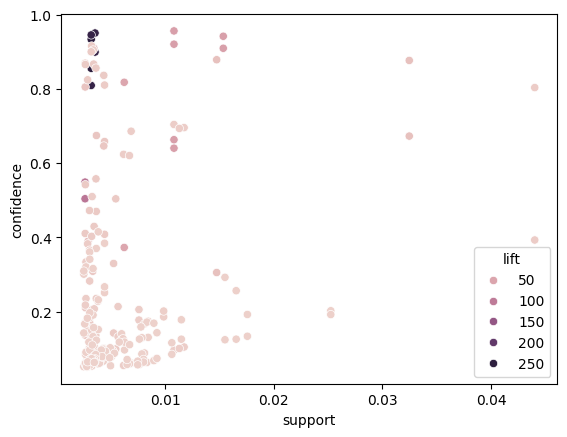

In [146]:
import seaborn as sns
# Plot scatter x-axis support, y-axis confidence, color lift
sns.scatterplot(data=rules_df, x='support', y='confidence', hue='lift')

<Axes: xlabel='support', ylabel='confidence'>

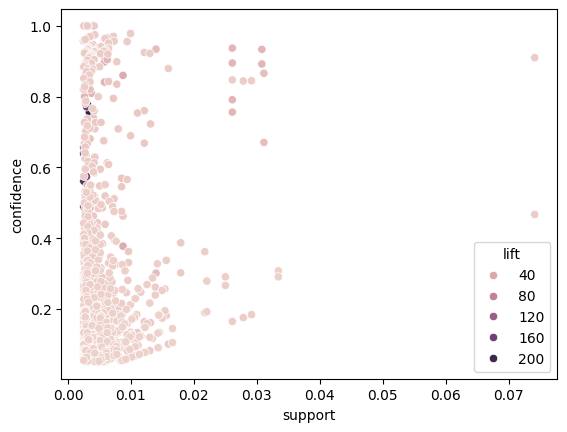

In [172]:
import seaborn as sns
# Plot scatter x-axis support, y-axis confidence, color lift
sns.scatterplot(data=rules_df_2, x='support', y='confidence', hue='lift')

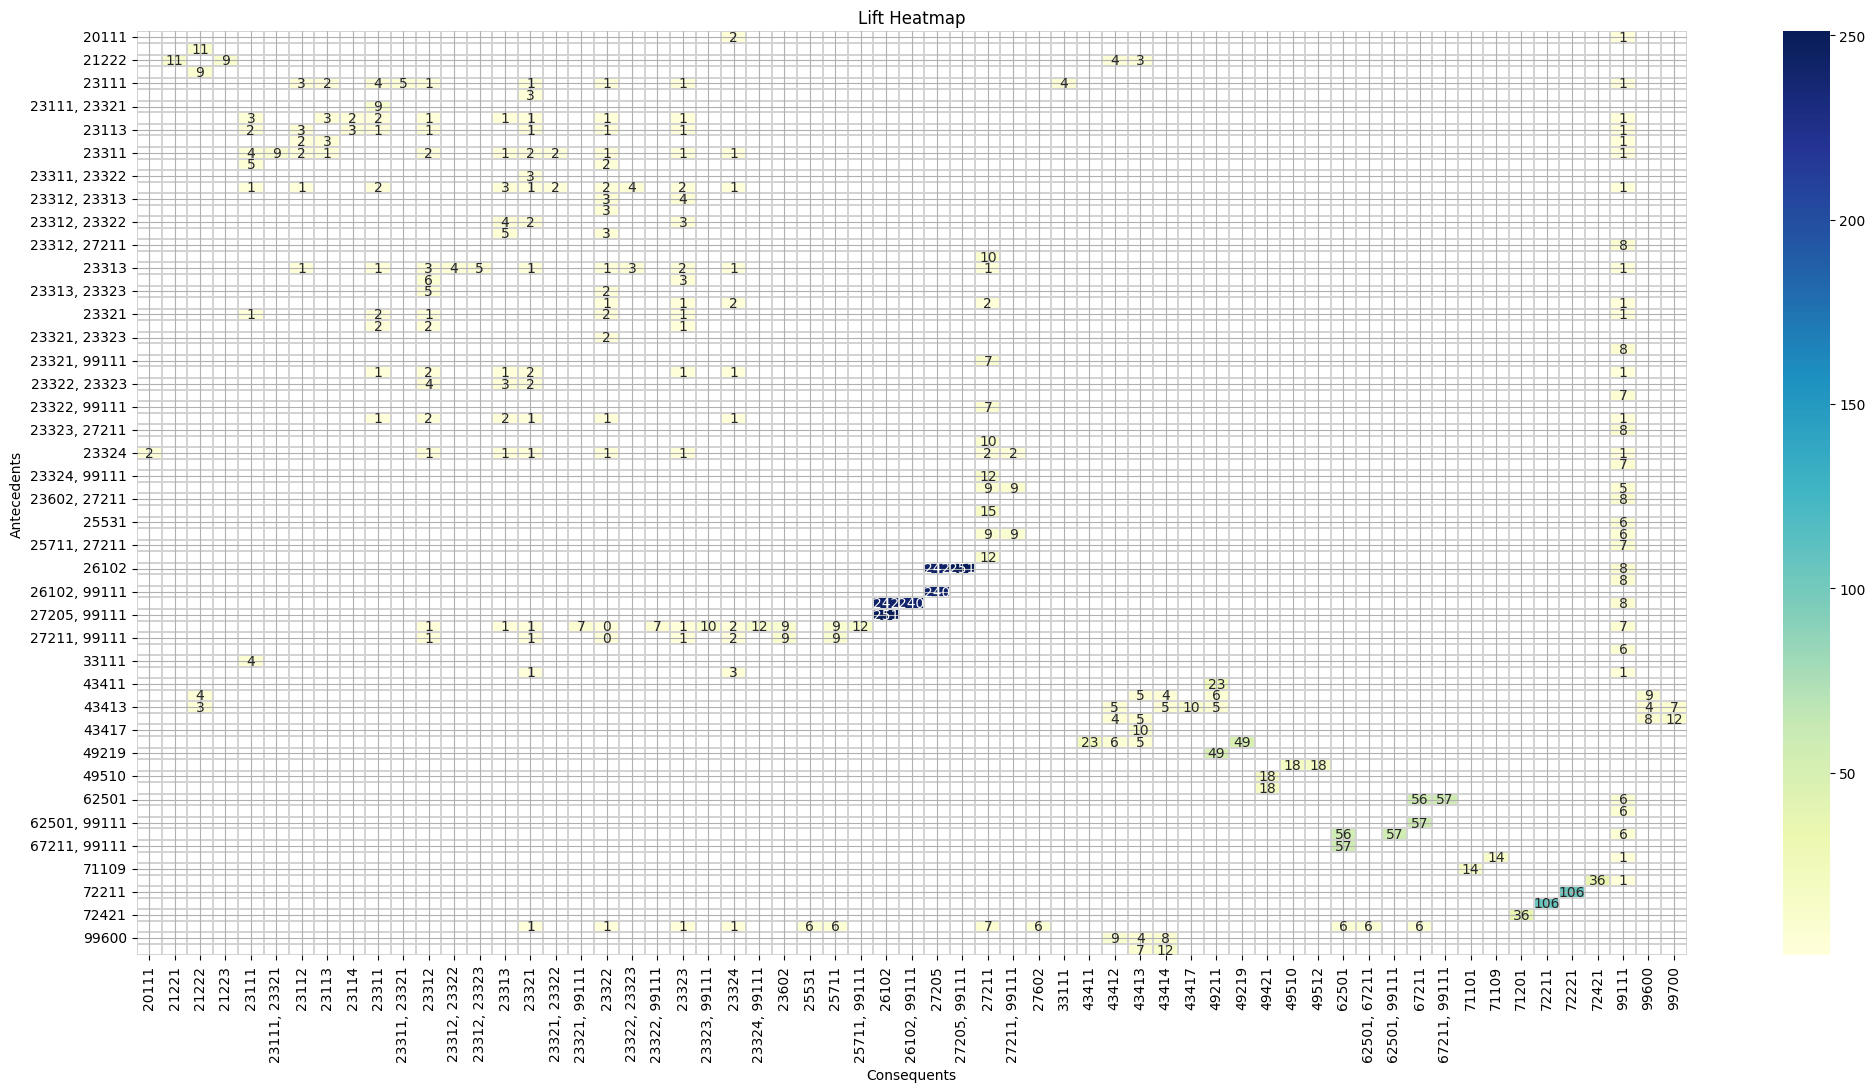

In [156]:
# # Convert frozensets to string representations
# rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: ', '.join(map(str, sorted(x))))
# rules_df['consequents'] = rules_df['consequents'].apply(lambda x: ', '.join(map(str, sorted(x))))

# # Create the pivot table for the heatmap
# pivot = rules_df.pivot(index='antecedents', columns='consequents', values='lift')

# Plot the heatmap with adjusted grid lines
plt.figure(figsize=(25, 12))  # Make the plot wider horizontally
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='.0f', cbar=True, linewidths=0.3, linecolor='lightgray', square=False)
plt.title('Lift Heatmap')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.grid(True)  # Ensure the grid is visible
plt.show()

In [188]:
top_rules = rules_df[rules_df['lift'] > 50].sort_values(by='lift', ascending=False)
print(top_rules[['antecedents', 'consequents', 'lift']])

        antecedents   consequents        lift
241         (26102)  27205, 99111  251.027484
239  (99111, 27205)         26102  251.027484
125         (27205)         26102  241.797057
124         (26102)         27205  241.797057
242         (27205)  26102, 99111  240.476316
238  (99111, 26102)         27205  240.476316
176         (72211)         72221  105.776041
175         (72221)         72211  105.776041
248         (62501)  67211, 99111   56.678413
243  (67211, 99111)         62501   56.678413
247         (67211)  62501, 99111   56.503368
244  (62501, 99111)         67211   56.503368
163         (67211)         62501   55.827523
164         (62501)         67211   55.827523


In [182]:
# # Convert frozensets to string representations
rules_df_2['antecedents'] = rules_df_2['antecedents'].apply(lambda x: ', '.join(map(str, sorted(x))))
rules_df_2['consequents'] = rules_df_2['consequents'].apply(lambda x: ', '.join(map(str, sorted(x))))
# # Create the pivot table for the heatmap
pivot = rules_df_2.pivot(index='antecedents', columns='consequents', values='lift')

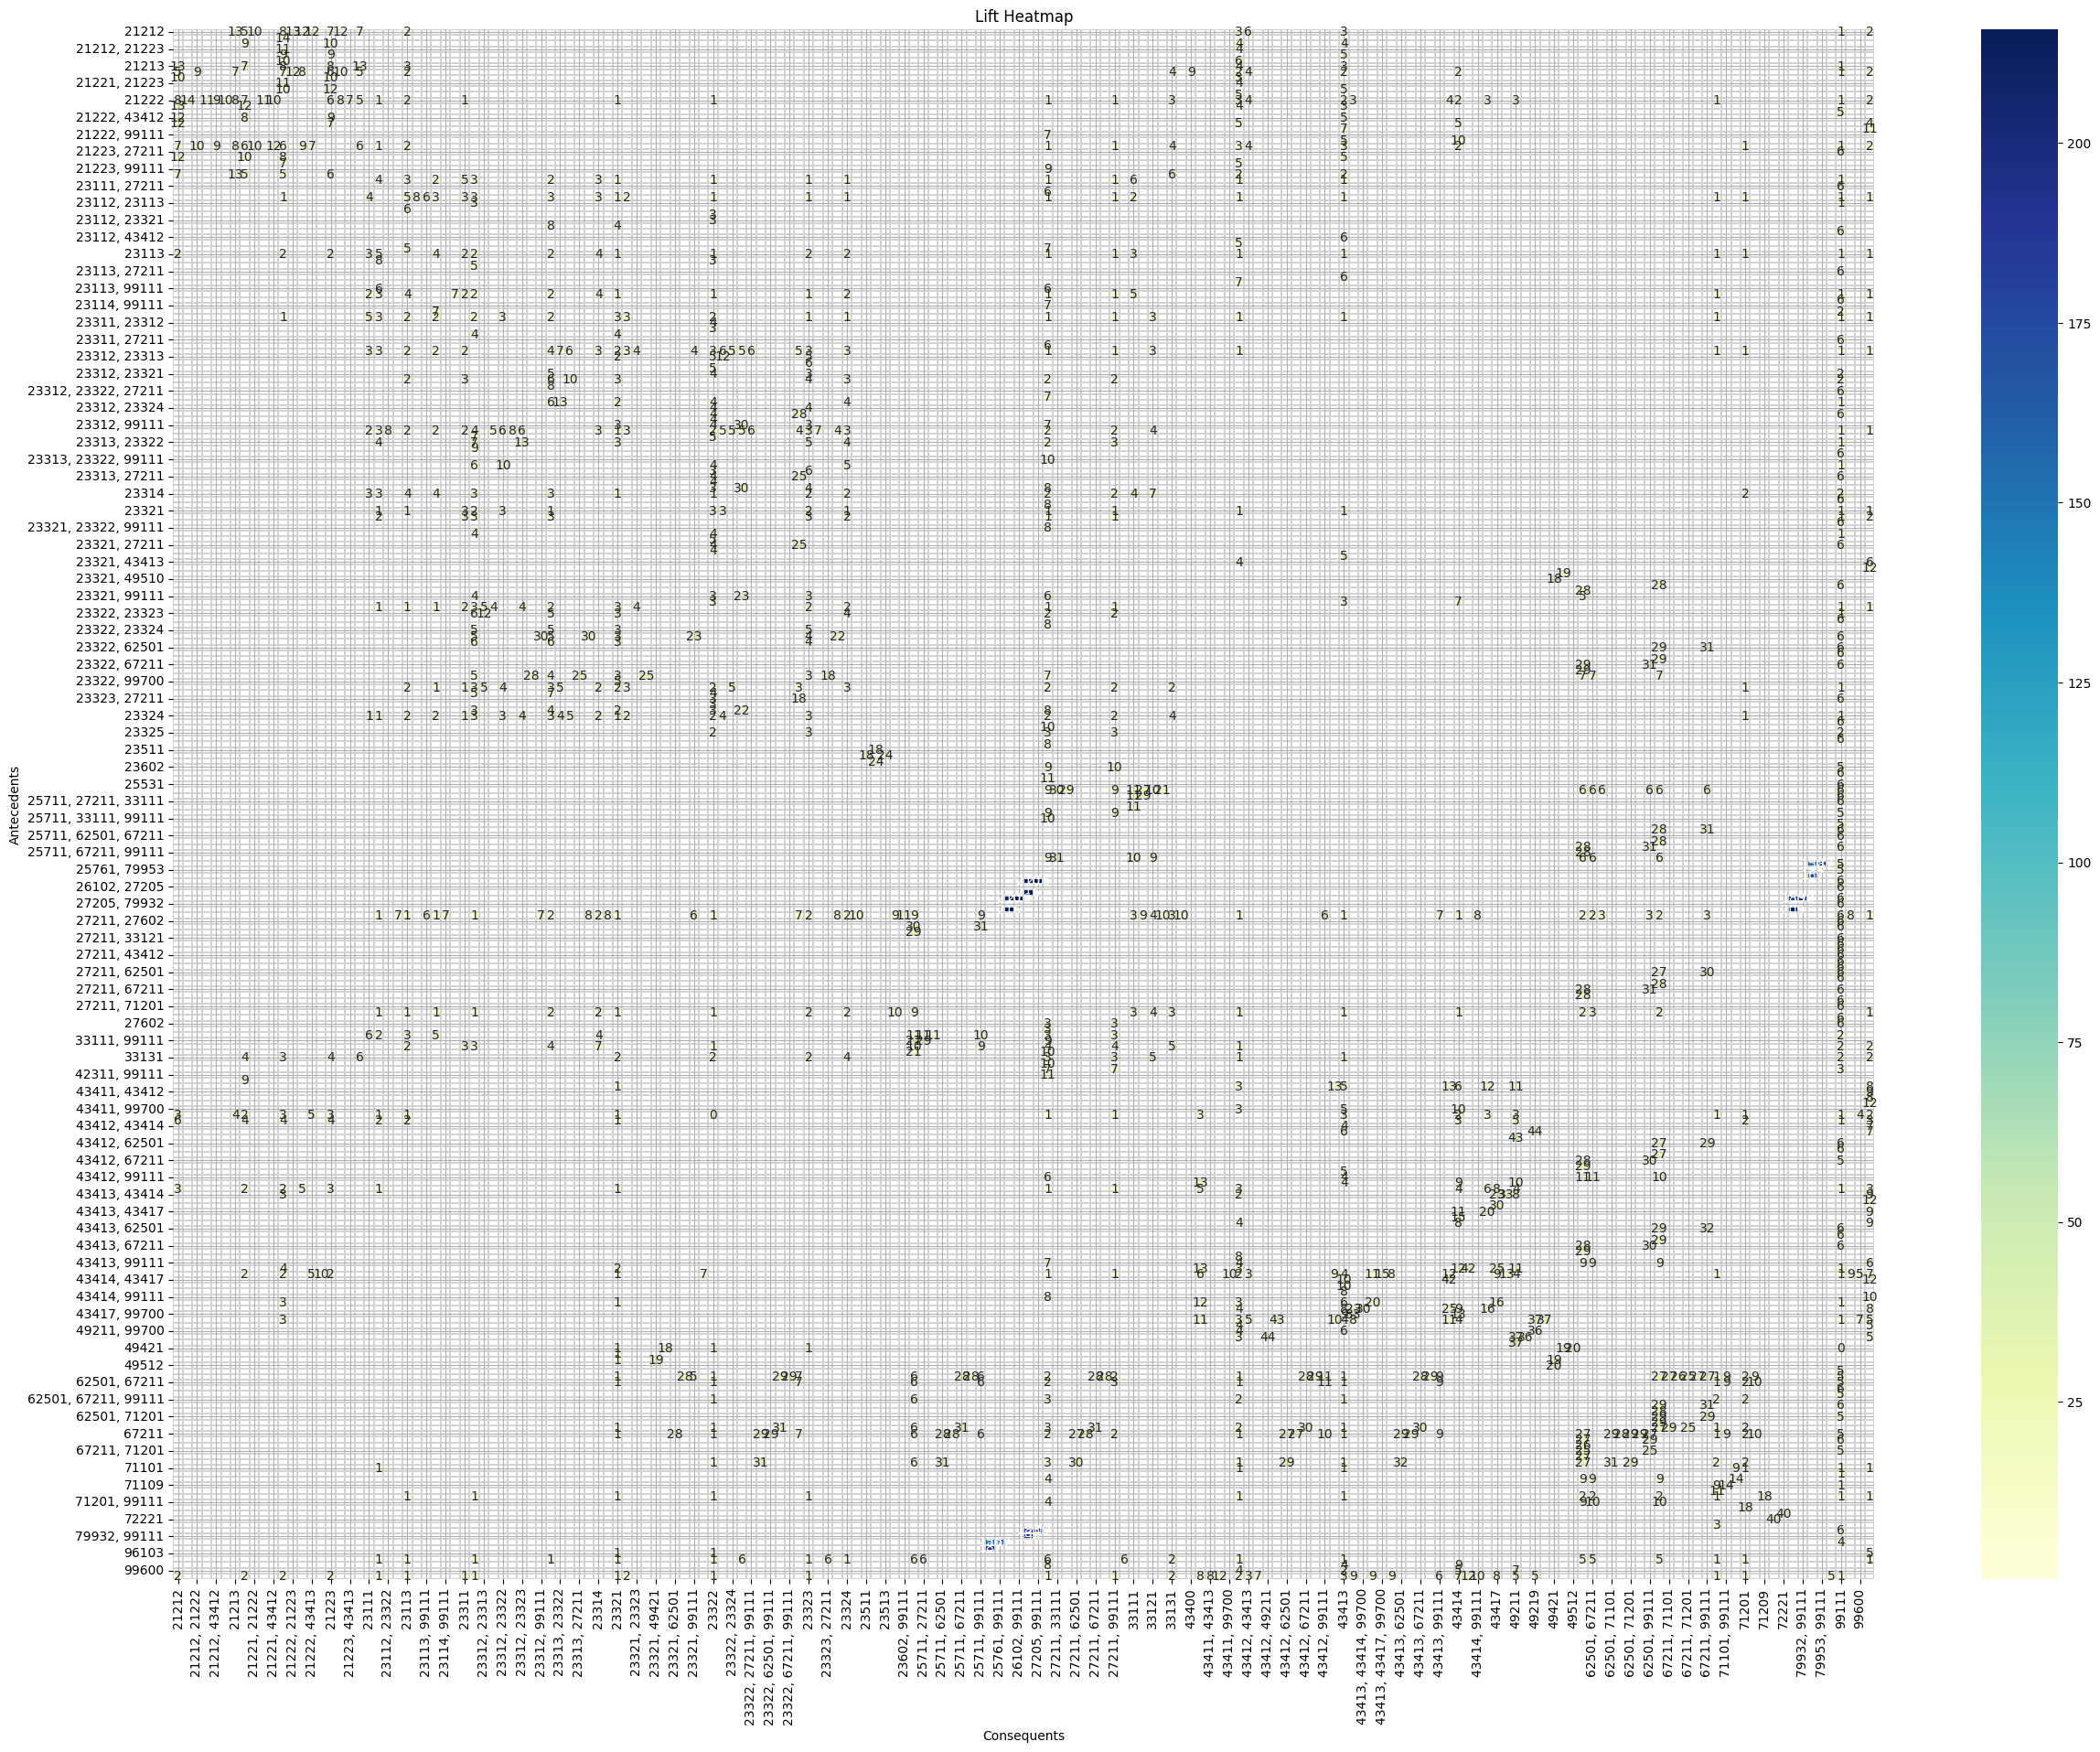

In [187]:
# Plot the heatmap with adjusted grid lines
plt.figure(figsize=(30, 22))  # Make the plot wider horizontally
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='.0f', cbar=True, linewidths=0.3, linecolor='lightgray', square=False)
plt.title('Lift Heatmap')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.grid(True)  # Ensure the grid is visible
plt.show()

### Sequantial Exploration

In [190]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Make sure the date column is in datetime format
df = df_treat_joined_n1.copy()
df['procedure_date'] = pd.to_datetime(df['procedure_date'])

# Sort the data by patient and date
df = df.sort_values(['patient_id', 'procedure_date'])

# Container to store results
results = []

# Iterate over each patient
for patient_id, group in df.groupby('patient_id'):
    group = group.reset_index(drop=True)
    
    # Set the min and max date for sliding window
    min_date = group['procedure_date'].min()
    max_date = group['procedure_date'].max()
    
    # Start sliding the window
    start_date = min_date
    while start_date <= max_date:
        # Define the end date for the current window (6 months ahead)
        end_date = start_date + DateOffset(months=6)
        
        # Filter rows in the current 6-month window
        mask_current = (group['procedure_date'] >= start_date) & (group['procedure_date'] < end_date)
        window_data_current = group.loc[mask_current]
        
        # Define the end date for the next 6-month window (look ahead)
        start_date_next = end_date
        end_date_next = start_date_next + DateOffset(months=6)
        
        # Filter rows in the next 6-month window
        mask_next = (group['procedure_date'] >= start_date_next) & (group['procedure_date'] < end_date_next)
        window_data_next = group.loc[mask_next]
        
        if not window_data_current.empty or not window_data_next.empty:
            results.append({
                'patient_id': patient_id,
                'current_window_start': start_date,
                'current_window_end': end_date,
                'next_window_start': start_date_next,
                'next_window_end': end_date_next,
                'current_procedure_codes': sorted(window_data_current['procedure_code_y'].tolist()),
                'next_procedure_codes': sorted(window_data_next['procedure_code_y'].tolist())
            })
        
        # Slide the window by 3 months
        start_date += DateOffset(months=3)

# Create final dataframe
df_input_total_sq = pd.DataFrame(results)
df_input_total_sq

,patient_id,current_window_start,current_window_end,next_window_start,next_window_end,current_procedure_codes,next_procedure_codes
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,"[1103, 12101, 2112, 21212, 21221, 2142, 25711,...",[1203]
1,1.0,1991-07-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,[1203],[]
2,1.0,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,[1203],[2142]
3,1.0,1992-01-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,[],"[1203, 2142, 43413]"
4,1.0,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,1993-04-30 00:00:00+00:00,[2142],"[1203, 43413, 43413]"
...,...,...,...,...,...,...,...
297805,13580.0,2024-09-18 00:00:00+00:00,2025-03-18 00:00:00+00:00,2025-03-18 00:00:00+00:00,2025-09-18 00:00:00+00:00,"[1102, 1102, 1102, 1102, 11107, 11107, 11107, ...",[]
297806,13583.0,2024-09-10 00:00:00+00:00,2025-03-10 00:00:00+00:00,2025-03-10 00:00:00+00:00,2025-09-10 00:00:00+00:00,"[1204, 2111]",[]
297807,13584.0,2024-09-21 00:00:00+00:00,2025-03-21 00:00:00+00:00,2025-03-21 00:00:00+00:00,2025-09-21 00:00:00+00:00,"[94303, 94303]",[]
297808,13586.0,2024-09-16 00:00:00+00:00,2025-03-16 00:00:00+00:00,2025-03-16 00:00:00+00:00,2025-09-16 00:00:00+00:00,"[1205, 2111, 23115, 23115, 23115, 27211, 99111...",[]


In [191]:
# Filter to only v1 and v3 data
df_input = df_input_total_sq[df_input_total_sq['patient_id'].isin(v1v3_map['patient_id'])]
df_input

,patient_id,current_window_start,current_window_end,next_window_start,next_window_end,current_procedure_codes,next_procedure_codes
0,1.0,1991-04-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,"[1103, 12101, 2112, 21212, 21221, 2142, 25711,...",[1203]
1,1.0,1991-07-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,1992-01-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,[1203],[]
2,1.0,1991-10-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,[1203],[2142]
3,1.0,1992-01-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,1992-07-30 00:00:00+00:00,1993-01-30 00:00:00+00:00,[],"[1203, 2142, 43413]"
4,1.0,1992-04-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,1992-10-30 00:00:00+00:00,1993-04-30 00:00:00+00:00,[2142],"[1203, 43413, 43413]"
...,...,...,...,...,...,...,...
296493,12898.0,2023-11-27 00:00:00+00:00,2024-05-27 00:00:00+00:00,2024-05-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,"[1204, 71101]","[23321, 23321, 23512, 23512, 71101]"
296494,12898.0,2024-02-27 00:00:00+00:00,2024-08-27 00:00:00+00:00,2024-08-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,"[1204, 23321, 23321, 23512, 23512, 71101, 71101]","[11107, 11107, 11111, 11111, 1202, 1202, 12113..."
296495,12898.0,2024-05-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,2024-11-27 00:00:00+00:00,2025-05-27 00:00:00+00:00,"[23321, 23321, 23512, 23512, 71101]","[11107, 11107, 11111, 11111, 1202, 1202, 12113..."
296496,12898.0,2024-08-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,2025-02-27 00:00:00+00:00,2025-08-27 00:00:00+00:00,"[11107, 11107, 11111, 11111, 1202, 1202, 12113...",[]


In [194]:
# Dict mapping patient name to patient id, df_treat_joined_n1
df_patient = df_treat_joined_n1[['patient_id', 'patient']].drop_duplicates()

# Get patient name in the input dataframe
df_input = df_input.merge(df_patient, left_on='patient_id', right_on='patient_id', how='left')

# rearrange the columns
df_input = df_input[['patient_id', 'current_procedure_codes', 'next_procedure_codes']]

# df_input.to_csv(r'D:\UofT\Research\SmilePass\Data_1301\21_treatements_backup_joined_patients_procedure_grouped_windowed_sequential.csv', index=False)

# Function to filter out procedure codes and remove duplicates
def filter_codes(codes):
    # Keep codes with length >= 5 and exclude codes with 5 digits starting with 1
    filtered_codes = [code for code in codes if len(str(code)) >= 5 and not (len(str(code)) == 5 and str(code).startswith('1'))]
    # Remove duplicates by converting to a set and then back to a list
    return list(set(filtered_codes))

# Apply the filtering function
df_input['current_procedure_codes'] = df_input['current_procedure_codes'].apply(filter_codes)
df_input['next_procedure_codes'] = df_input['next_procedure_codes'].apply(filter_codes)

# Drop rows where procedure_codes become empty after filtering
df_input_rem = df_input[df_input['current_procedure_codes'].str.len() > 0].reset_index(drop=True)
df_input_rem = df_input_rem[df_input_rem['next_procedure_codes'].str.len() > 0].reset_index(drop=True)

from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd


# Create a DataFrame for encoding procedure codes as one-hot features
def encode_procedures(df, col_name):
    # Create a list of all unique procedure codes (from both current and next)
    all_codes = list(set([code for codes in df[col_name] for code in codes]))
    
    # Create a one-hot encoded DataFrame
    encoded_df = pd.DataFrame(columns=all_codes)
    
    # Fill the DataFrame with 1s where the procedure code is present
    for idx, row in df.iterrows():
        codes = set(row[col_name])
        encoded_df.loc[idx] = [1 if code in codes else 0 for code in all_codes]
    
    return encoded_df

# Encode current and next procedure codes separately
encoded_current = encode_procedures(df_input_rem, 'current_procedure_codes')
encoded_next = encode_procedures(df_input_rem, 'next_procedure_codes')

# Combine the current and next encoded DataFrames, but not flatten them
# This ensures that we maintain separate columns for current and next treatments
encoded_combined = pd.concat([encoded_current, encoded_next], axis=1)

# Apply the Apriori algorithm on the combined dataset (current + next)
frequent_itemsets_combined = apriori(encoded_combined, min_support=0.0025, use_colnames=True)


# Generate association rules from current to next treatment (antecedents -> consequents)
rules_combined = association_rules(frequent_itemsets_combined, metric="confidence", min_threshold=0.5, num_itemsets=len(frequent_itemsets_combined))


# Filter the rules to make sure antecedents are current treatments and consequents are next treatments
rules_combined['antecedents'] = rules_combined['antecedents'].apply(lambda x: set(x).intersection(set(encoded_current.columns)))
rules_combined['consequents'] = rules_combined['consequents'].apply(lambda x: set(x).intersection(set(encoded_next.columns)))

# Filter out rules where either antecedents or consequents are empty
rules_combined = rules_combined[rules_combined['antecedents'].str.len() > 0]
rules_combined = rules_combined[rules_combined['consequents'].str.len() > 0]

# Display the generated sequential rules
print("Sequential Rules (Current -> Next Treatments):")
print(rules_combined[['antecedents', 'consequents', 'lift']])

c:\Users\frank\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Sequential Rules (Current -> Next Treatments):
               antecedents     consequents        lift
0                  {99111}         {23321}  121.470085
1                  {23321}         {99111}  121.470085
2                  {23323}         {23321}  232.384615
3                  {23321}         {23323}  232.384615
4                  {23321}         {23113}   12.309723
..                     ...             ...         ...
302  {79932, 99111, 27205}         {26102}  113.355932
303  {79932, 26102, 27205}         {99111}  105.097143
304         {79932, 99111}  {26102, 27205}   96.167320
305         {79932, 26102}  {99111, 27205}  112.671148
306         {79932, 27205}  {99111, 26102}  118.977898

[307 rows x 3 columns]


In [195]:
# Convert frozensets to string representations for both antecedents and consequents
rules_combined['antecedents'] = rules_combined['antecedents'].apply(lambda x: ', '.join(map(str, sorted(x))))
rules_combined['consequents'] = rules_combined['consequents'].apply(lambda x: ', '.join(map(str, sorted(x))))

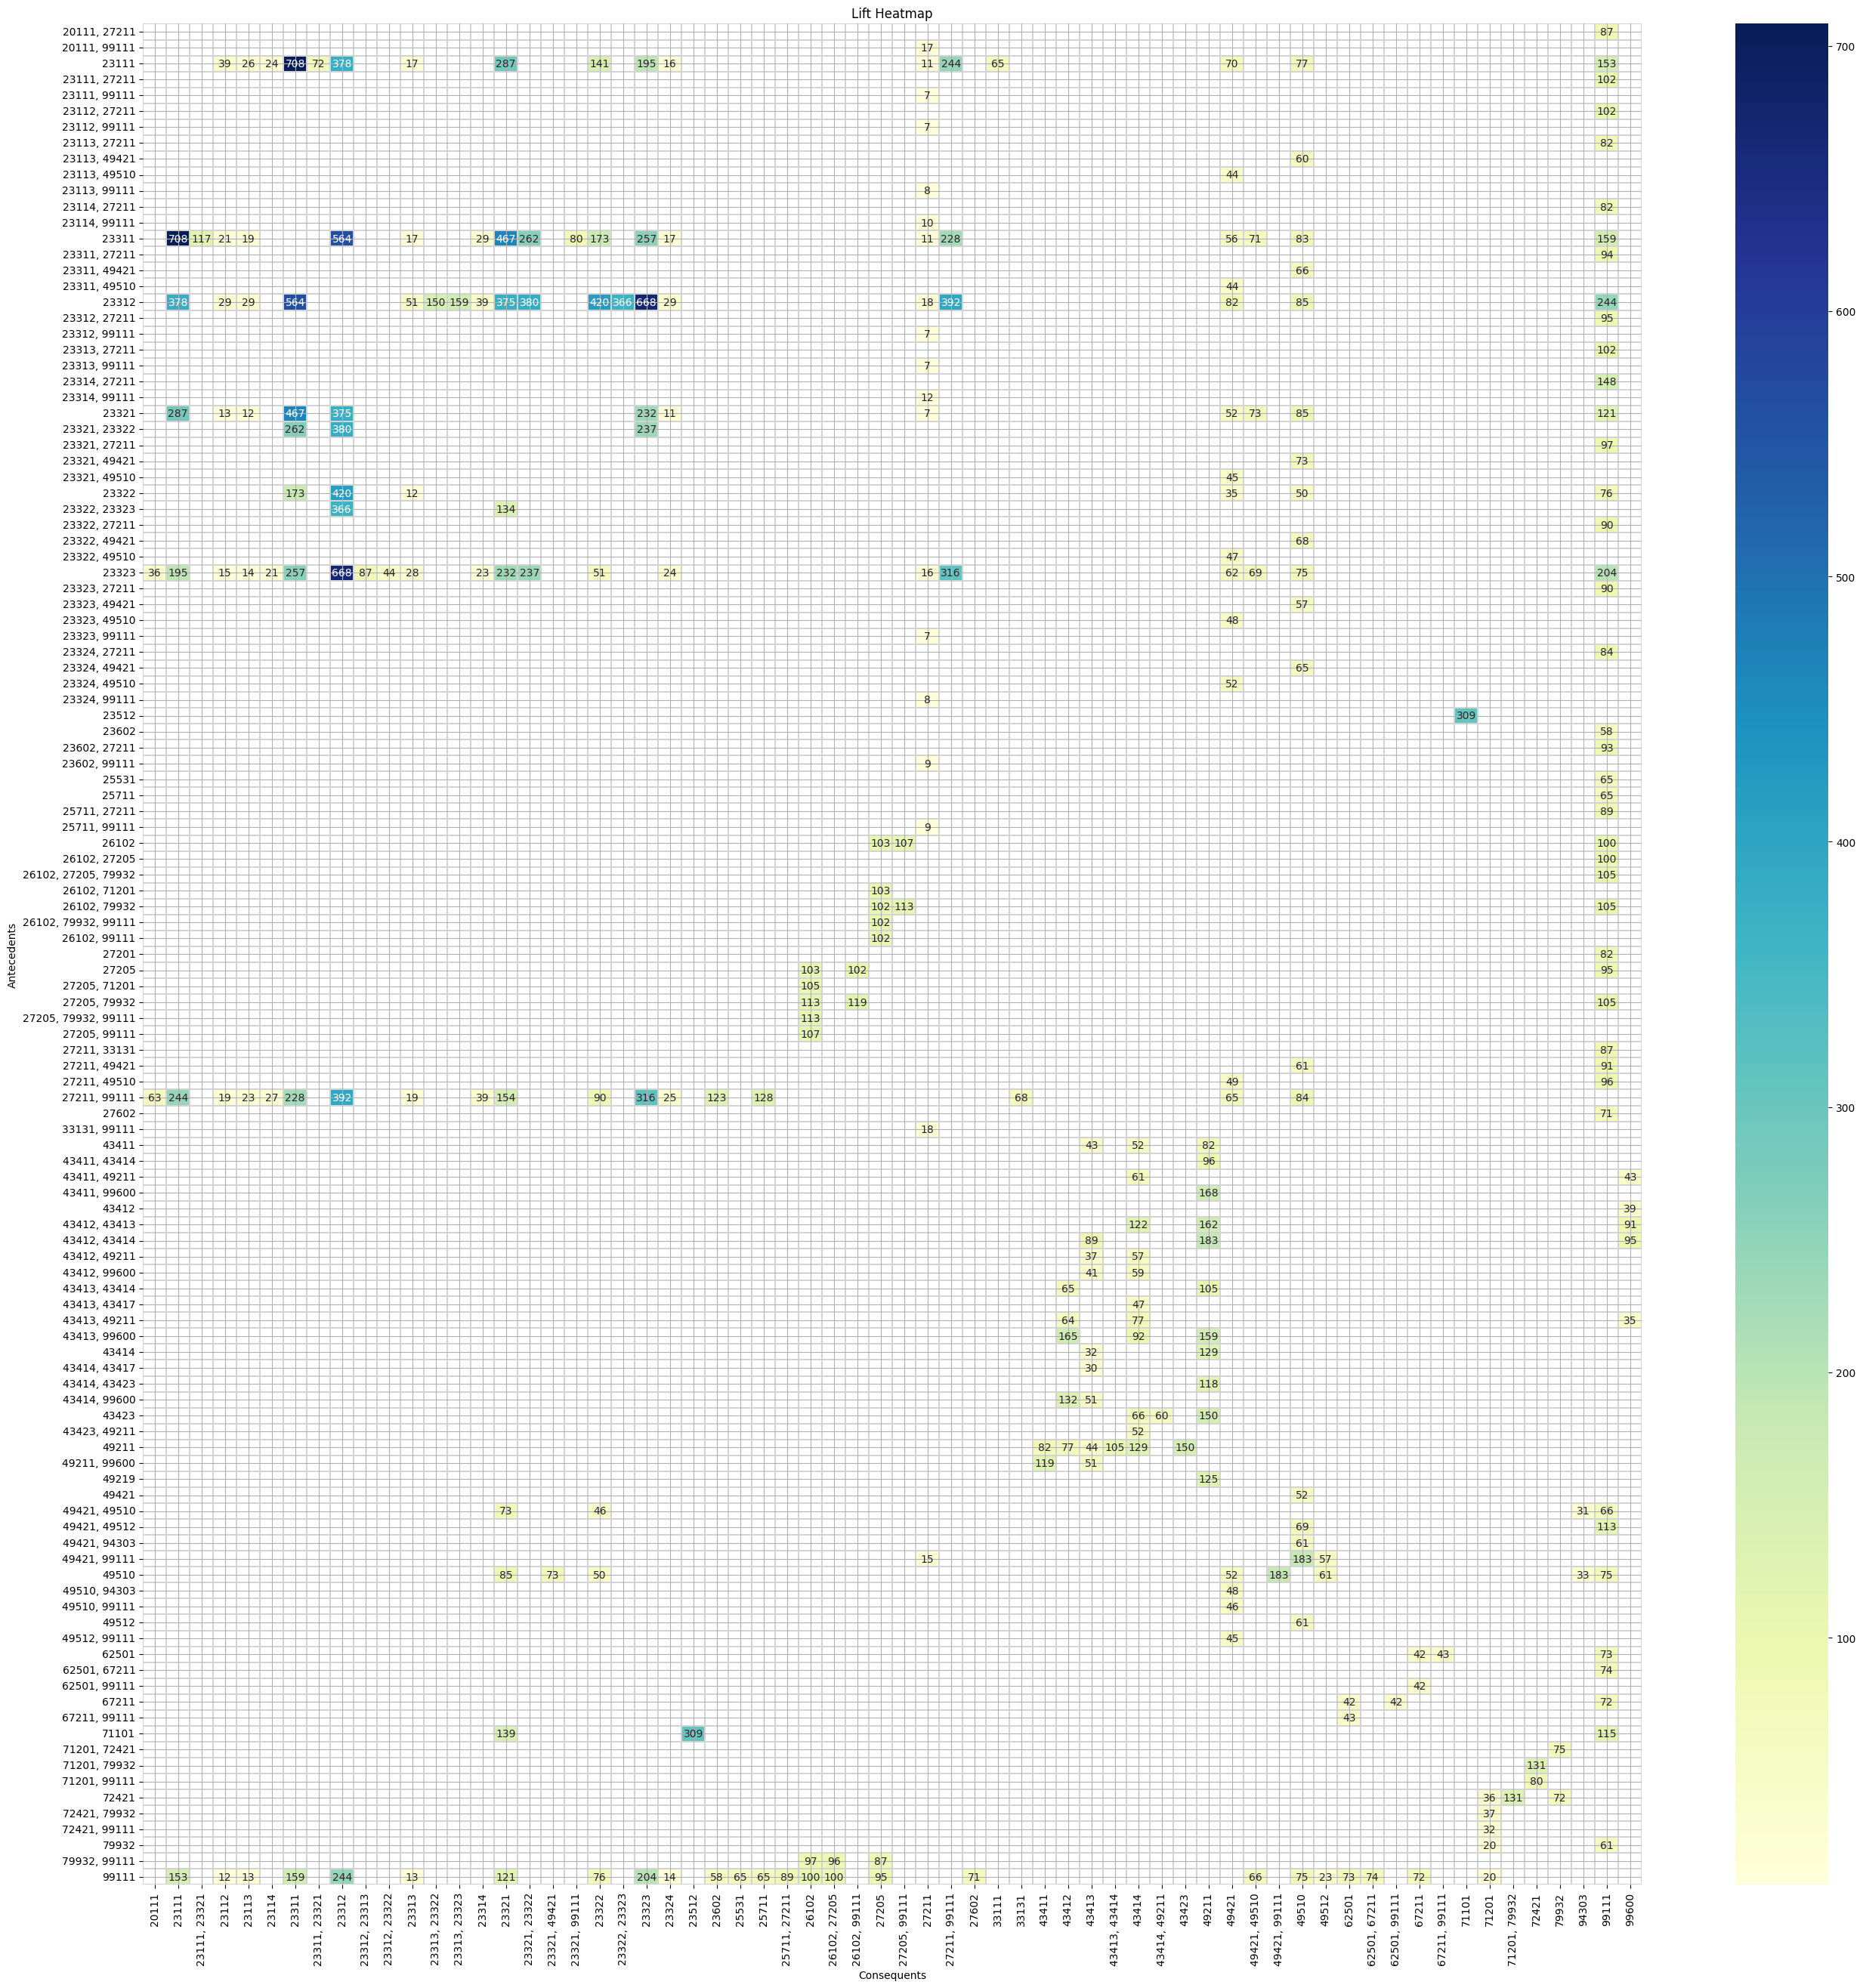

In [196]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create the pivot table for the heatmap (using string representations now)
pivot = rules_combined.pivot(index='antecedents', columns='consequents', values='lift')

# Plot the heatmap with adjusted grid lines
plt.figure(figsize=(32, 32))  # Make the plot wider horizontally
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='.0f', cbar=True, linewidths=0.3, linecolor='lightgray', square=False)
plt.title('Lift Heatmap')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.grid(True)  # Ensure the grid is visible
plt.show()
